In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os
import shutil

In [2]:
train_csv = 'dataset/train/_classes.csv'
valid_csv = 'dataset/valid/_classes.csv'
test_csv = 'dataset/test/_classes.csv'
base_dir = 'dataset\\'

In [4]:
img_height, img_width = 150, 150
batch_size = 32
epochs = 20

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=50.0
)

In [6]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1051 images belonging to 3 classes.


In [8]:
valid_generator = valid_datagen.flow_from_directory(
    os.path.join(base_dir, 'valid'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 124 images belonging to 3 classes.


In [30]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))  # Lapisan tambahan
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [31]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False  # Membekukan lapisan

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7749 - loss: 0.5132 - val_accuracy: 0.6979 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7500 - loss: 0.5330 - val_accuracy: 0.6071 - val_loss: 0.7181 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.7621 - loss: 0.5132 - val_accuracy: 0.7292 - val_loss: 0.5717 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8750 - loss: 0.3390 - val_accuracy: 0.7143 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7884 - loss: 0.4721 - val_accuracy: 0.6875 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7500 - loss: 0.5988 - val_accuracy: 0.7857 - val_loss: 0.5152 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8336 - loss: 0.3925 - val_accurac

In [37]:
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 92 images belonging to 3 classes.


In [38]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.2f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7708 - loss: 0.4480
Test accuracy: 0.78


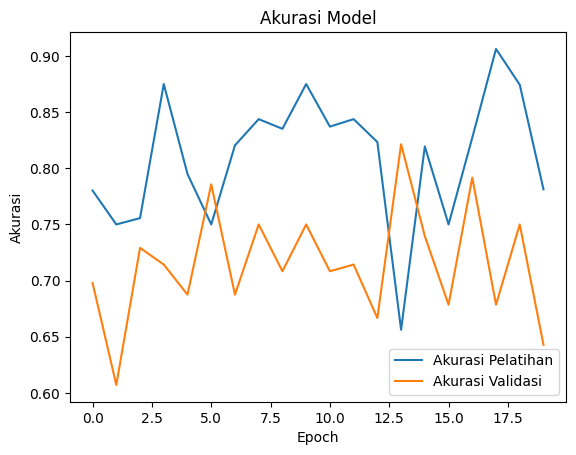

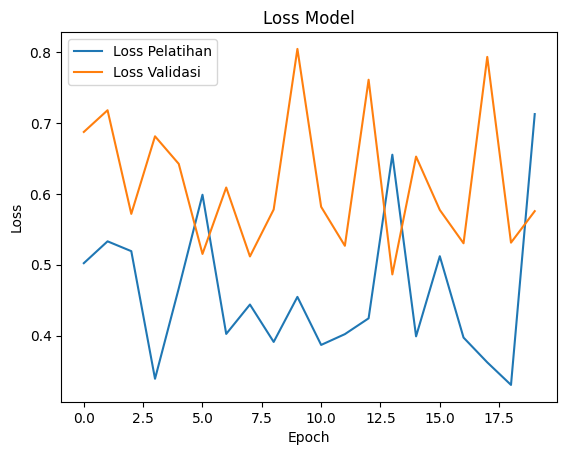

In [39]:
import matplotlib.pyplot as plt

# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
